In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd 'drive/My Drive/Thesis'

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# import uniform distribution
from scipy.stats import uniform
from scipy.stats import binom
import scipy.special as sc
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.stats import pareto
from scipy.stats import truncnorm
import time
np.random.seed(5)

In [2]:
def auction_exp(data_auction, p):
    """Train a normalizing flow model with maximum likelihood.

    Args:
        model: normalizing flow model. Flow or StackedFlows
        dataset: dataset containing data to fit. Dataset
        batch_size: number of samples per batch. int
        max_epochs: number of training epochs. int
        frequency: frequency for plotting density visualization. int
        
    Return:
        model: trained model. Flow or StackedFlows
        losses: loss evolution during training. list of floats
    """
    revenue = 0
    for bid in data_auction:
        if bid >= p:
          #change the bidder with price p
          revenue += p
    
    revenue = revenue/len(data_auction)
    return revenue

In [3]:
def rejection_sampling(pi1, pi2, N):

    # def f(x):
    #   return [x[0] * (1 + np.log(x[1]/x[0])) - u,
    #           x[0] *(2*x[1]-x[0]) - u**2 - sigma**2]


    # root = fsolve(f, [ini1,ini2])

    # pi1 = min(root)
    # pi2 = max(root)
    #using rejection sampling, get N random price samples
    n = 0
    #A =(pi2/pi1-1)*(pi2-pi1)/don
    don = pi2*np.log(pi2/pi1) - (pi2-pi1)
    env =(pi2/pi1-1)/don
    rej_sample =[]
    while(n <= N):
        x = uniform.rvs(loc=pi1, scale=pi2-pi1)
        a = (pi2/x-1)/don/env
        u1 = uniform.rvs()
        if (u1 <= a):
            rej_sample.append(x)
            n += 1
    return rej_sample

In [4]:
#Pareto(1) distribution, changing sigma for unifrom distribution while keep u fixed

#Azard and Marcili k(r) function
def k_r(x):
    return (0.5*(3*x +x**3) -1/r_m)
#Equavelent funtion like A&M, but using consistent notation with Robust paper
def rho_tilde(x):
    return ((x-1)**3)/(x**2) - (27/4)*r_m**2 
#Deterministic DAPX from the Robust paper
def rho_D(x):
    return ((x-1)**3)/((2*x-1)**2) - r_m**2  

def log_lottery(x):
    return (x * (1 + np.log(cons_m/(x**2) + 1) - np.log(2)) -u_m )

tic = time.clock()
sigma_list = []
u_m_list=[]
r_list =[]
reserve_p_list = []
p_d_list = []
sigma_list = []
c_list =[]
rho_list =[]
rev_A_list = []
rev_A1_list=[]
DAPX = []
DAPX_A1 = []
DAPX_A2 = []
#bundling price for Azar and Micali mechanism
p_AM = []
p_AM_list = []
p_A1_list = []
rev_A2_list = []
p_A2_list = []
APX_pareto1_list =[]
APX_rev_list=[]
step = np.arange(2, 51,1)
n = 100000
k = 30
c = 2.01
u, var = pareto.stats(c, moments='mv')
sigma = np.sqrt(var)
r = sigma/u
p_opt = 1
for m in step:
    
    bid_pareto1 = []
    bid_pareto1= pareto.rvs(c,size=n)

    
    #Compute expected revenue for A1:selling separately with optimal reserve price
    rev_A1 = m*auction_exp(bid_pareto1,p_opt)
    rev_A1_list.append(rev_A1)

    
    #Generate randome variables Y, where Y = sum (X1,X2,...,Xm)
    j = 0
    bundlebid_pareto1 = []
    while j < n:
        bid = pareto.rvs(c,size=m)
        bundlebid_pareto1.append(sum(bid))
        j += 1

    #Compute the mean and standard deviation for the convolution of the Perato(0) distributions    
    u_m = m*u
    u_m_list.append(u_m)
    sigma_m = np.sqrt(m)*sigma
    r_m = sigma_m/u_m
#     p_d = fsolve(F, [u_m])
#     print(F(p_d))
#     p_reserve = p_d*u_m/(2*p_d-1)

                
##### This is direct implementation for Azard and Marcili mechanism
#     k = fsolve(k_r, [u])
#     print(k_r(k))
#     p.append(u - k*sigma)

    # This is equavelent to the Azard and Marcili mechanism, just different notation
    # Here we obtain the expected revenue for Azard and Marcili mechanism
    rho = fsolve(rho_tilde, [u_m])
    p_AM = u_m*(rho+2)/(3*rho)
    p_AM_list.append(p_AM)
    print(rho_tilde(rho))
    rev_A = auction_exp(bundlebid_pareto1,p_AM)
    rev_A_list.append(rev_A[0])
    
    DAPX.append(u_m/rev_A[0])
    DAPX_A1.append(rev_A1/rev_A)
    
    # Here we obtain the expected revenue for A2: selling it grand bundle with optimal reserve price
    # We use discretization here
    prices = np.linspace(p_AM,u_m,k+2)[1:] #we want k discrete values between p_AM and u_m, here we also include u_m to have a look
    rev = []
    for p in prices:
        rev.append(auction_exp(bundlebid_pareto1,p))
    #Store the highest expected revenue and corresponding reserve price    

    rev_A2 = max(rev)
    rev_A2_list.append(rev_A2[0])    
    p_A2_list.append(prices[np.argmax(rev)])
    DAPX_A2.append(rev_A2/rev_A[0])
    
    #compute the APX using full-bundle log lottery randomization 
    cons_m = u_m**2 + sigma_m**2
    pi1 = fsolve(log_lottery, [u_m-0.2])
    pi2 = 0.5*(cons_m/pi1 +pi1)
    print(log_lottery(pi1))
    rej_sample = []
    rej_sample = rejection_sampling(pi1,pi2,10000)
    rexp_revenue_list =[]
    for rp_reserve in rej_sample:
        rexp_revenue_list.append(auction_exp(bundlebid_pareto1,rp_reserve))
  
    APX_rev = np.average(rexp_revenue_list)
    APX_rev_list.append(APX_rev)
    APX_pareto1_list.append(u_m/APX_rev)
    
    
toc = time.clock()
print('time: ' + str(toc-tic))    
# print('the expected revenue for Azard and Marcili: ' + str(rev_A))    
# print('the expected revenue for selling separately: ' + str(rev_A1))
# print('the expected revenue for boundle selling: ' + str(rev_A2))

C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


[0.]
[0.]
[2.84217094e-14]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.77635684e-15]
[0.]
[3.55271368e-15]
[0.]
[3.55271368e-15]
[7.10542736e-15]
[7.10542736e-15]
[-7.10542736e-15]
[3.55271368e-15]
[3.55271368e-15]
[3.55271368e-15]
[3.55271368e-15]
[0.]
[0.]
[3.55271368e-15]
[-3.55271368e-15]
[0.]
[0.]
[0.]
[-3.55271368e-15]
[7.10542736e-15]
[0.]
[0.]
[0.]
[0.]
[-3.55271368e-15]
[3.33955086e-13]
[0.]
[5.68434189e-14]
[-1.77635684e-15]
[1.42108547e-14]
[-1.77635684e-15]
[7.10542736e-15]
[0.]
[0.]
[5.32907052e-15]
[-7.10542736e-15]
[1.42108547e-14]
[0.]
[2.30926389e-14]
[1.42108547e-14]
[4.61852778e-14]
[-7.10542736e-15]
[7.81597009e-14]
[7.10542736e-15]
[0.]
[-4.61852778e-13]
[0.]
[-1.20792265e-13]
[0.]
[-3.55271368e-14]
[1.77635684e-15]
[-1.42108547e-14]
[0.]
[1.42108547e-14]
[0.]
[0.]
[1.77635684e-15]
[0.]
[1.77635684e-15]
[-1.42108547e-14]
[-1.77635684e-15]
[1.42108547e-14]
[-1.77635684e-15]
[1.42108547e-14]
[1.77635684e-15]
[0.]
[1.77635684e-15]
[0.]
[0.]
[1.42108547e-14]
[-8.8817842e-16]
[1.4

C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:121: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
c = 2.01
u, var = pareto.stats(c, moments='mv')
sigma = np.sqrt(var)
r = sigma/u
r

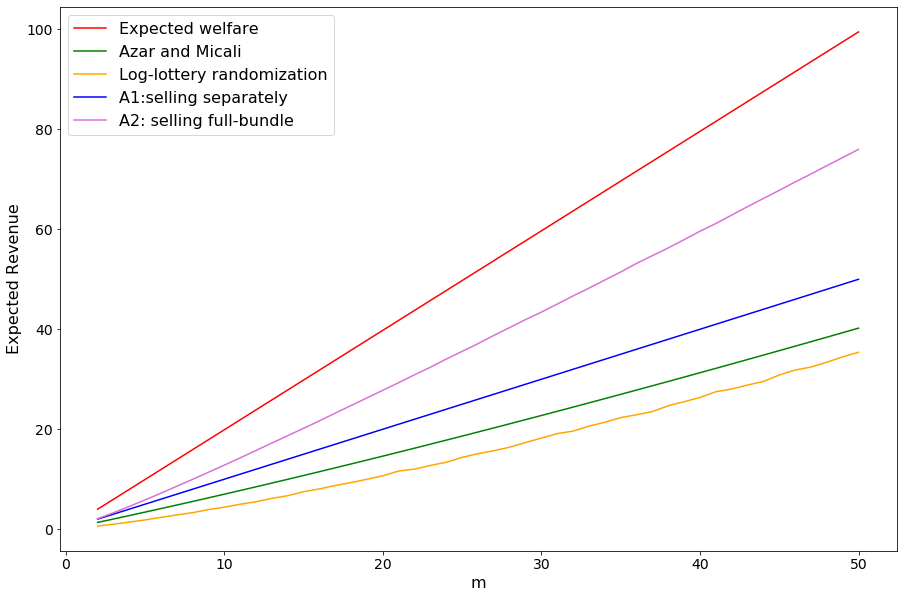

In [6]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 14)
plt.tick_params(axis='y', labelsize= 14)
#ax2.axhline(0,color="red")
plt.xlabel("m",fontsize=16)
plt.ylabel("Expected Revenue",fontsize=16)
# plt.axhline(u_m,color="red",label="Expected welfare")
plt.plot(step, u_m_list, color="red",label="Expected welfare")
plt.plot(step, rev_A_list,color="green",label="Azar and Micali")
plt.plot(step, APX_rev_list,  color="#FFA500",label="Log-lottery randomization")
plt.plot(step, rev_A1_list, color="blue",label="A1:selling separately")
plt.plot(step, rev_A2_list,  color="orchid",label="A2: selling full-bundle")

plt.legend(loc="upper left",fontsize = 16)
plt.savefig("p1c2_items.png",bbox_inches='tight')

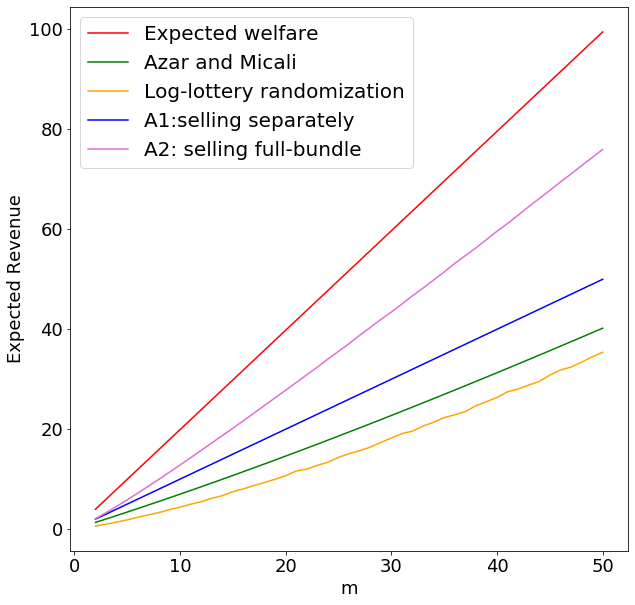

In [8]:
plt.figure(figsize=(10,10))
plt.tick_params(axis='x', labelsize= 18)
plt.tick_params(axis='y', labelsize= 18)
#ax2.axhline(0,color="red")
plt.xlabel("m",fontsize=18)
plt.ylabel("Expected Revenue",fontsize=18)
# plt.axhline(u_m,color="red",label="Expected welfare")
plt.plot(step, u_m_list, color="red",label="Expected welfare")
plt.plot(step, rev_A_list,color="green",label="Azar and Micali")
plt.plot(step, APX_rev_list,  color="#FFA500",label="Log-lottery randomization")
plt.plot(step, rev_A1_list, color="blue",label="A1:selling separately")
plt.plot(step, rev_A2_list,  color="orchid",label="A2: selling full-bundle")

plt.legend(loc="upper left",fontsize = 20)
plt.savefig("p1c2_items_s.png",bbox_inches='tight')

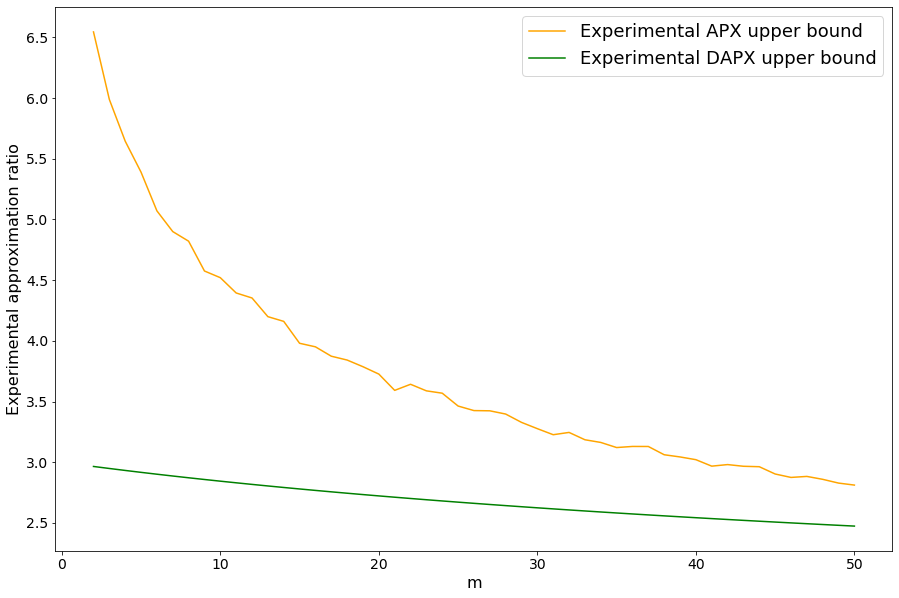

In [10]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 14)
plt.tick_params(axis='y', labelsize= 14)
#ax2.axhline(0,color="red")
plt.xlabel("m",fontsize=16)
plt.ylabel("Experimental approximation ratio",fontsize=16)
# plt.axhline(u_m,color="red",label="Expected welfare")
#plt.plot(step, rho_list, color="pink",label="rho")
plt.plot(step, APX_pareto1_list, color="#FFA500",label="Experimental APX upper bound")
plt.plot(step, DAPX, color="green",label="Experimental DAPX upper bound")

plt.legend(loc="best",fontsize = 18)
plt.savefig("p1c2_ratio.png",bbox_inches='tight')

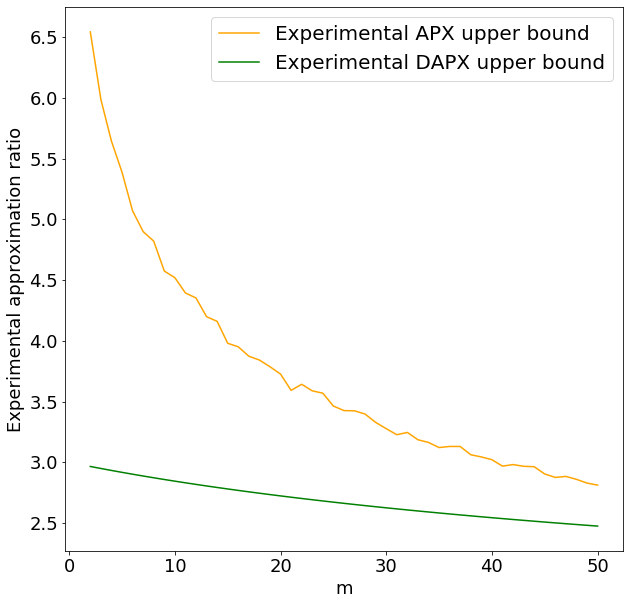

In [12]:
plt.figure(figsize=(10,10))
plt.tick_params(axis='x', labelsize= 18)
plt.tick_params(axis='y', labelsize= 18)
#ax2.axhline(0,color="red")
plt.xlabel("m",fontsize=18)
plt.ylabel("Experimental approximation ratio",fontsize=18)
# plt.axhline(u_m,color="red",label="Expected welfare")
#plt.plot(step, rho_list, color="pink",label="rho")
plt.plot(step, APX_pareto1_list, color="#FFA500",label="Experimental APX upper bound")
plt.plot(step, DAPX, color="green",label="Experimental DAPX upper bound")

plt.legend(loc="best",fontsize = 20)
plt.savefig("p1c2_ratio_s.png",bbox_inches='tight')

In [14]:
import pandas as pd 
  
# creating the DataFrame 
my_df = { 'step' : step[0],
          'u_m_list': u_m_list,
         'rev_A_list': rev_A_list,
         'APX_rev_list': APX_rev_list,
         'rev_A1_list': rev_A1_list,
         'rev_A2_list': rev_A2_list,
         'DAPX': DAPX,
         'APX_pareto1_list': APX_pareto1_list
         } 
df = pd.DataFrame(my_df) 
  
   
# saving the DataFrame as a CSV file 
gfg_csv_data = df.to_csv('p1c2_items.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data) 


CSV String:
 None


In [ ]:
len(APX_pareto1_list)